In [13]:
import tensorflow as tf
import numpy as np
import cv2

from PIL import Image
from keras import applications
from keras.optimizers import Adam, SGD
from keras import backend as k 
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.models import Sequential, Model
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D, Conv2D, MaxPooling2D, Dropout, BatchNormalization
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping, ReduceLROnPlateau
from pprint import pprint as pp

img_width, img_height = 122, 122
train_data_dir = "dataset/train"
validation_data_dir = "dataset/validation"
test_data_dir = "dataset/test1"
nb_train_samples = 9375
nb_validation_samples = 3125
batch_size = 100
nb_steps_per_epoch = nb_train_samples / batch_size
epochs = 2000
classes = 2
lr = 0.001   

k.tensorflow_backend._get_available_gpus() 

['/gpu:0']

In [2]:
class CustomCNN:
    @staticmethod
    def build(input_shape = (img_width, img_height, 3), classes=classes):                             
        model = Sequential()
        
        model.add(BatchNormalization(input_shape=input_shape))
        
        model.add(Conv2D(32, (3, 3),activation='relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        
        model.add(Conv2D(32, (3, 3), activation='relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))

        model.add(Conv2D(64, (3, 3), activation='relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))

        model.add(Conv2D(64, (3, 3), activation='relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))        
        
        model.add(Flatten())
        model.add(Dense(64, activation='relu'))
        model.add(Dropout(0.5))
        model.add(Dense(1, activation='sigmoid'))
        
        return model

In [3]:
def create_datagen():
    return ImageDataGenerator(
        rescale = 1./255,
        fill_mode = "nearest",
        zoom_range = 0.2,
        width_shift_range = 0.1,
        height_shift_range=0.2,
        rotation_range=20)

def create_val_datagen():
    return ImageDataGenerator(rescale = 1./255)

# Initiate the train and test generators with data Augumentation 
train_datagen = create_datagen()
test_datagen = create_val_datagen()

train_generator = train_datagen.flow_from_directory(train_data_dir,
                                                    target_size = (img_height, img_width),
                                                    batch_size = batch_size, 
                                                    class_mode = "binary")    

validation_generator = test_datagen.flow_from_directory(validation_data_dir, 
                                                        target_size = (img_height, img_width), 
                                                        class_mode = "binary")

Found 18750 images belonging to 2 classes.
Found 6250 images belonging to 2 classes.


In [4]:
sgd_optimizer = SGD(lr=0.001, decay=1e-3, momentum=0.9, nesterov=False)
adam_optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

In [5]:
with tf.device('/gpu:0'): 
    model = CustomCNN.build(input_shape=(122,122,3), classes=classes)
    model.summary()
    # compile the model 
    model.compile(loss = "binary_crossentropy", 
                    optimizer = 'rmsprop', 
                    metrics=["accuracy"])

    lr_updater = ReduceLROnPlateau(monitor='val_acc', 
                               factor=0.5)

    checkpoint = ModelCheckpoint("custom_cnn.h5", 
                             monitor='val_acc', 
                             verbose=1, 
                             save_best_only=True, 
                             save_weights_only=False, 
                             mode='auto', 
                             period=1)

    early = EarlyStopping(monitor='val_acc', 
                      min_delta=0, 
                      patience=15, 
                      verbose=1, 
                      mode='auto')
    # Train the model 
    history = model.fit_generator(train_generator,
                              steps_per_epoch = nb_steps_per_epoch,
                              epochs = epochs,
                              validation_data = validation_generator,
                              verbose = 1,
                              callbacks = [checkpoint, lr_updater, early])


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_1 (Batch (None, 122, 122, 3)       12        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 120, 120, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 60, 60, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 58, 58, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 29, 29, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 27, 27, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 13, 13, 64)        0         
__________

94/93 [==============================] - 60s 639ms/step - loss: 0.3125 - acc: 0.8656 - val_loss: 0.2565 - val_acc: 0.8939

Epoch 00033: val_acc improved from 0.89312 to 0.89392, saving model to custom_cnn.h5
Epoch 34/2000
94/93 [==============================] - 60s 637ms/step - loss: 0.3197 - acc: 0.8639 - val_loss: 0.2613 - val_acc: 0.8872

Epoch 00034: val_acc did not improve
Epoch 35/2000
94/93 [==============================] - 60s 636ms/step - loss: 0.3101 - acc: 0.8645 - val_loss: 0.2438 - val_acc: 0.9019

Epoch 00035: val_acc improved from 0.89392 to 0.90192, saving model to custom_cnn.h5
Epoch 36/2000
94/93 [==============================] - 60s 639ms/step - loss: 0.3088 - acc: 0.8733 - val_loss: 0.5988 - val_acc: 0.7666

Epoch 00036: val_acc did not improve
Epoch 37/2000
94/93 [==============================] - 60s 636ms/step - loss: 0.3002 - acc: 0.8699 - val_loss: 0.2222 - val_acc: 0.9082

Epoch 00037: val_acc improved from 0.90192 to 0.90816, saving model to custom_cnn.h5


94/93 [==============================] - 60s 638ms/step - loss: 0.2243 - acc: 0.9056 - val_loss: 0.2391 - val_acc: 0.9110

Epoch 00077: val_acc did not improve
Epoch 78/2000
94/93 [==============================] - 60s 639ms/step - loss: 0.2418 - acc: 0.8996 - val_loss: 0.1822 - val_acc: 0.9318

Epoch 00078: val_acc improved from 0.92880 to 0.93184, saving model to custom_cnn.h5
Epoch 79/2000
94/93 [==============================] - 60s 640ms/step - loss: 0.2289 - acc: 0.8999 - val_loss: 0.2294 - val_acc: 0.8984

Epoch 00079: val_acc did not improve
Epoch 80/2000
94/93 [==============================] - 60s 635ms/step - loss: 0.2326 - acc: 0.9047 - val_loss: 0.1818 - val_acc: 0.9245

Epoch 00080: val_acc did not improve
Epoch 81/2000
94/93 [==============================] - 60s 639ms/step - loss: 0.2225 - acc: 0.9043 - val_loss: 0.1850 - val_acc: 0.9243

Epoch 00081: val_acc did not improve
Epoch 82/2000
94/93 [==============================] - 60s 636ms/step - loss: 0.2413 - acc: 0.89

dict_keys(['val_loss', 'val_acc', 'loss', 'acc', 'lr'])


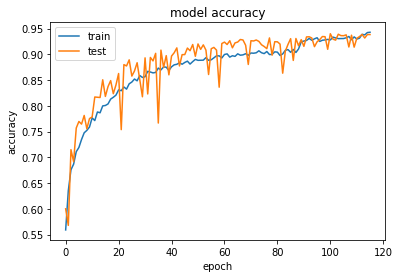

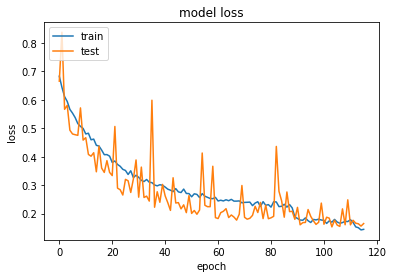

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

[[1]]


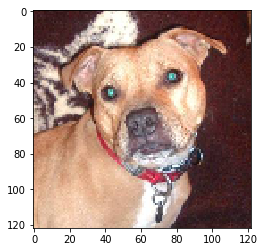

In [16]:
# predicting images
# 1 dog - not cat, 0 cat - not dog
img = load_img(test_data_dir + '/2.jpg', target_size=(img_width, img_height))
x = img_to_array(img)
x = np.expand_dims(x, axis=0)

plt.imshow(img)

images = np.vstack([x])
pred = model.predict_classes(images, batch_size=10)
print(pred)

[[0]]


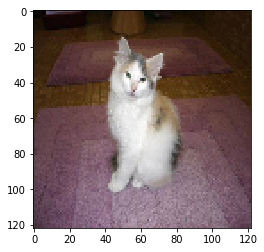

In [17]:
# predicting images
# 1 dog - not cat, 0 cat - not dog
img = load_img(test_data_dir + '/10.jpg', target_size=(img_width, img_height))
x = img_to_array(img)
x = np.expand_dims(x, axis=0)

plt.imshow(img)

images = np.vstack([x])
pred = model.predict_classes(images, batch_size=10)
print(pred)

[[1]]


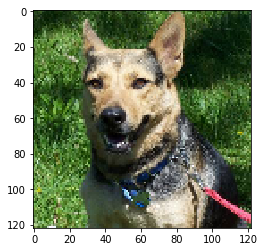

In [18]:
# predicting images
# 1 dog - not cat, 0 cat - not dog
img = load_img(test_data_dir + '/42.jpg', target_size=(img_width, img_height))
x = img_to_array(img)
x = np.expand_dims(x, axis=0)

plt.imshow(img)

images = np.vstack([x])
pred = model.predict_classes(images, batch_size=10)
print(pred)

[[0]]


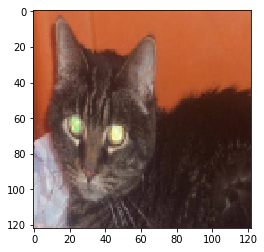

In [19]:
# predicting images
# 1 dog - not cat, 0 cat - not dog
img = load_img(test_data_dir + '/96.jpg', target_size=(img_width, img_height))
x = img_to_array(img)
x = np.expand_dims(x, axis=0)

plt.imshow(img)

images = np.vstack([x])
pred = model.predict_classes(images, batch_size=10)
print(pred)